<a href="https://colab.research.google.com/github/changsksu/IMSE_Data_Science/blob/main/MEWMA_Control_Chart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This code demonstrates how you can plot MEWMA control Chart when n=1 using the T2 statistic.

---

Note that this code should work for the Phase I and II of the control charting.
Just make sure mu and sigma are estimated from the Phase I dataset.

In [ ]:
# Import required libraries
from scipy.stats import beta
from scipy.stats import f
from scipy.stats import multivariate_normal
import numpy as np
import statistics
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import pandas as pd
plt.style.use('seaborn-colorblind')

In [ ]:
# retrive data for Drug Effect data k=3
data = pd.read_csv('https://raw.githubusercontent.com/changsksu/K-State-IMSE641/master/Hotelling_T2.csv', sep=',', na_values=".")
#generate the Phase I data using filter
#use the first 18 observations to setup the control charts
dataI= [data[['Fever', 'Pressure', 'Aches']][data['ID'] == "Placebo"]]

#retrieve the Phase II data
dataII= [data[['Fever', 'Pressure', 'Aches']][data['ID'] == "Drug"]]

#all data points; the data type is a list
dataAll=[data[['Fever', 'Pressure', 'Aches']]]

dataI

[    Fever  Pressure  Aches
 0    40.9        54     14
 1    39.5        75     18
 2    39.4        57     24
 3    38.2        71     24
 4    39.7        65     22
 5    38.9        49     30
 6    38.6        58     25
 7    39.9        52     17
 8    41.3        62     18
 9    38.1        57     20
 10   39.6        78     19
 11   37.1        92     15
 12   39.5        63     13
 13   40.3        52     25
 14   41.5        46     27
 15   39.3        56     14
 16   37.6        86     16
 17   40.6        48     21]

In [ ]:
# this np.reshape convert the list dataI into the proper subgroup and m=18
x1=np.reshape(dataI, (18,3))

In [ ]:
# this np.reshape convert the list dataI into the proper subgroup and m=38
x3=np.reshape(dataAll, (38,3))
x3

In [ ]:
# compute column means since x1 is the Phase I data
mean1=np.mean(x1, axis=0)
mean1

array([39.44444444, 62.27777778, 20.11111111])

In [ ]:
# compute the covariance matrix based on Phase I data
matcov1 = np.cov(x1.T)
matcov1

array([[  1.49673203, -10.43071895,   0.64771242],
       [-10.43071895, 175.15359477, -28.5620915 ],
       [  0.64771242, -28.5620915 ,  24.45751634]])

In [ ]:
x1[0]

array([40.9, 54. , 14. ])

In [ ]:
dif=x1[0]-mean1
dif

array([ 1.45555556, -8.27777778, -6.11111111])

In [ ]:
lam=0.15
Ztminus1=0
Zt= lam * dif + (1-lam) * Ztminus1
Zt

array([ 0.17333333, -2.14166667,  0.13333333])

In [ ]:
 # validating the computational results in the function def fit(self, data, lam, H, mu, sigma):
 Z = []
 DIF=[]
Ztminus1=np.zeros(3)
for sample in x1:
    dif = sample - mean1
    Zt= lam * dif + (1-lam) * Ztminus1
    Z.append(Zt)
    Ztminus1=Zt
    DIF.append(dif)
DIF

[array([ 1.45555556, -8.27777778, -6.11111111]),
 array([ 0.05555556, 12.72222222, -2.11111111]),
 array([-0.04444444, -5.27777778,  3.88888889]),
 array([-1.24444444,  8.72222222,  3.88888889]),
 array([0.25555556, 2.72222222, 1.88888889]),
 array([ -0.54444444, -13.27777778,   9.88888889]),
 array([-0.84444444, -4.27777778,  4.88888889]),
 array([  0.45555556, -10.27777778,  -3.11111111]),
 array([ 1.85555556, -0.27777778, -2.11111111]),
 array([-1.34444444, -5.27777778, -0.11111111]),
 array([ 0.15555556, 15.72222222, -1.11111111]),
 array([-2.34444444, 29.72222222, -5.11111111]),
 array([ 0.05555556,  0.72222222, -7.11111111]),
 array([  0.85555556, -10.27777778,   4.88888889]),
 array([  2.05555556, -16.27777778,   6.88888889]),
 array([-0.14444444, -6.27777778, -6.11111111]),
 array([-1.84444444, 23.72222222, -4.11111111]),
 array([  1.15555556, -14.27777778,   0.88888889])]

In [ ]:
# compute the center line of the MEWMA chart
matcov =lam/(2-lam) * matcov1
matinv = np.linalg.inv(matcov)  
dif_avgs=np.mean(DIF, axis=0)  
dif_avgs

array([ 1.57898386e-15, -7.89491929e-16,  3.94745964e-16])

In [ ]:
matinv.dot(dif_avgs.T).dot(dif_avgs)

3.606250652791537e-29

In [ ]:
class MEWMA:

    _title = "MEWMA Control Chart"

    def fit(self, data, lam, H, mu, sigma):
        # H is the upper control limits & lam is the EWMA coef lambda
        self.data = np.array(data)
        self.numsample = len(data)
        #size is p the number of variates
        self.size=len(np.mean(x1, axis=0))
        self.lam=lam
        self.H=H
        Z = []
        DIF=[]
        Ztminus1=np.zeros(self.size)
        for sample in data:
            dif = sample - mu
            Zt= lam * dif + (1-lam) * Ztminus1
            Z.append(Zt)
            Ztminus1=Zt
            DIF.append(dif)

        # compute EWMA and T2 statistics
        colmean = np.mean(data, axis=0)
        values = []
        i=1
        for zi in Z:
            matcov = lam*(1-(1-lam)**(2*i))/(2-lam) * sigma
            matinv = np.linalg.inv(matcov)      
            value = matinv.dot(zi.T).dot(zi)
            values.append(value)
            i+=1 
        
        matcov = lam/(2-lam) * sigma
        matinv = np.linalg.inv(matcov)  
        dif_avgs=np.mean(DIF, axis=0)    
       
        self.T2=values
        self.lcl = 0
        self.center = matinv.dot(dif_avgs.T).dot(dif_avgs)
        self.ucl = H

        #return (values, center, lcl, ucl, self._title)

    def ControlChart(self):
        ucl = np.zeros(self.numsample)
        lcl = np.zeros(self.numsample)
              
        for i in range(self.numsample):
            lcl[i] = self.lcl
            ucl[i] = self.ucl
              
        plt.figure(figsize=(15,5))
        plt.plot(self.T2,marker="o",color="k",label="T2")
        plt.plot([self.center]*self.numsample,color="k",alpha=0.35)
        plt.plot(ucl,color="r",label="UCL {}".format(ucl[len(ucl)-1].round(2)))
        plt.plot(lcl,color="r",label="LCL {}".format(lcl[len(lcl)-1].round(2)))
        plt.title("MEWMA Conrol Chart")
        plt.legend(loc="upper left")
        plt.show()


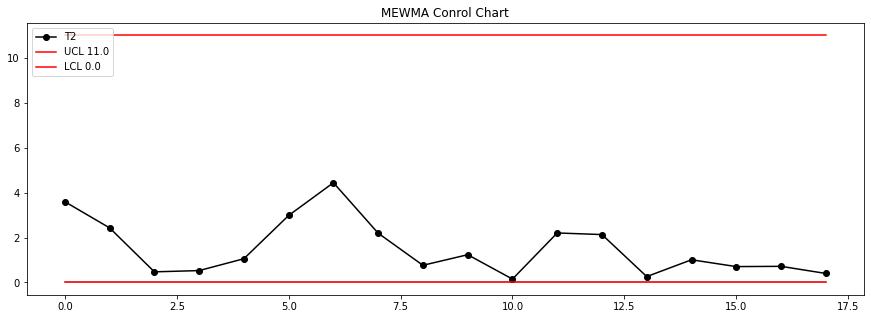

In [ ]:
# This chart is for Phase I or Phase II assuming all mean and sigma are estimated
# In this block, only Phase I data is plotted
# size is the number of variables
chart = MEWMA()
# use lambda=0.15 H=11 for delta=1.5 Ref Prabhu and Runger 1997
chart.fit(data=x1, lam=0.2, H=11, mu=mean1, sigma=matcov1)
chart.ControlChart()

# **Now we will use the mean and sigma estimated from the Phase I process above and plot all data**

Your turn: how do you control the mean and std so that only the Phase I data is used? Note that the following chart should use the same control limits as the phase I chart.

In [ ]:
# all data is converted into a proper matrix
x3=np.reshape(dataAll, (38,3))

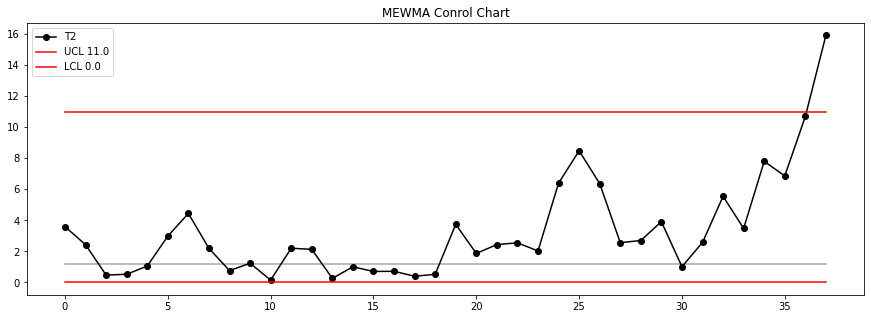

In [ ]:
# Now plot Phase II assuming all mean and sigma are estimated from Phase I data set
chart = MEWMA()
# use lambda=0.15 H=11 for delta=1.5 Ref Prabhu and Runger 1997
chart.fit(data=x3, lam=0.2, H=11, mu=mean1, sigma=matcov1)
chart.ControlChart()

Note that the first 18 samples are for patients with placebo while the last 20 observations are ptients with drug treamtment. The MEWMA allows the minor differences in each sample to become prominent 